# Plotting intermidiate network results

In [2]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

# utility function for nice plotting

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

This is the repository path:  c:\Users\Lenovo\Desktop\pypsa-earth
Had to go 1 folder(s) up.


# Load networks

In [3]:
#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

clustered_network = os.getcwd() + '/networks/elec_s_4.nc'
n_cluster = pypsa.Network(clustered_network)

solved_network = os.getcwd() + "/results/networks/elec_s_4_ec_lcopt_Co2L-1H.nc"
n_solve = pypsa.Network(solved_network)

base_network= os.getcwd() +  "/networks/base.nc"
n_base= pypsa.Network(base_network)



INFO:pypsa.io:Imported network elec_s_4.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_4_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base.nc has buses, lines, transformers


In [4]:
n_cluster

PyPSA Network
Components:
 - Bus: 4
 - Carrier: 13
 - Generator: 20
 - Line: 3
 - Load: 4
 - StorageUnit: 3
Snapshots: 8760

In [5]:
n_base

PyPSA Network 'PyPSA-Eur'
Components:
 - Bus: 155
 - Line: 322
 - Transformer: 39
Snapshots: 8760

In [6]:
n_solve

PyPSA Network
Components:
 - Bus: 12
 - Carrier: 16
 - Generator: 24
 - GlobalConstraint: 1
 - Line: 3
 - Link: 16
 - Load: 4
 - StorageUnit: 3
 - Store: 8
Snapshots: 8760

# Solved network

In [9]:
n = n_solve

# Node distribution

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


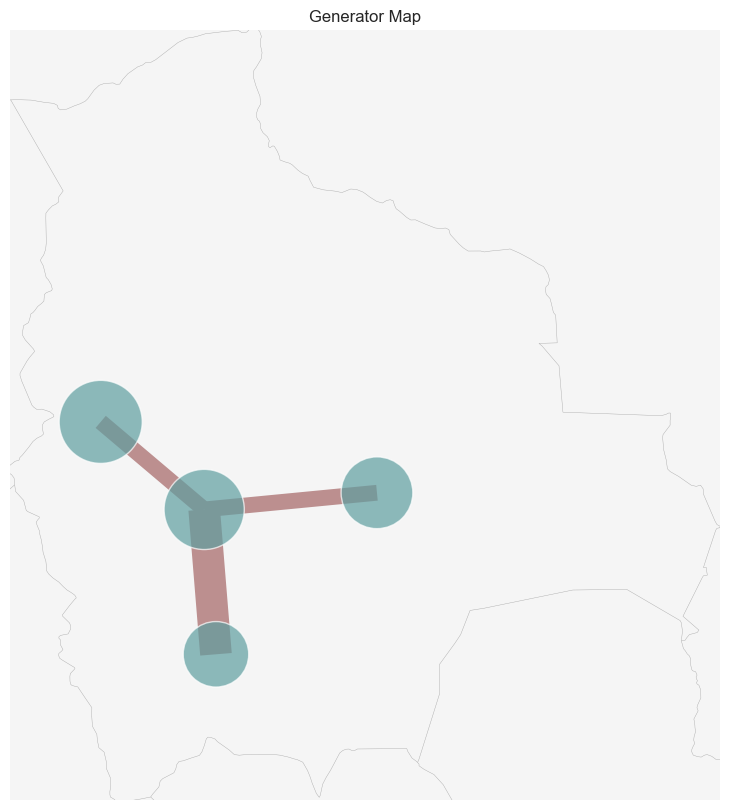

In [10]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=ax,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=0.7,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    )*0.5,  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 1e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31376\3988636640.py:182: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_buses = n.buses[~n.buses.index.str.contains(r" (H2|battery)$")]
c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


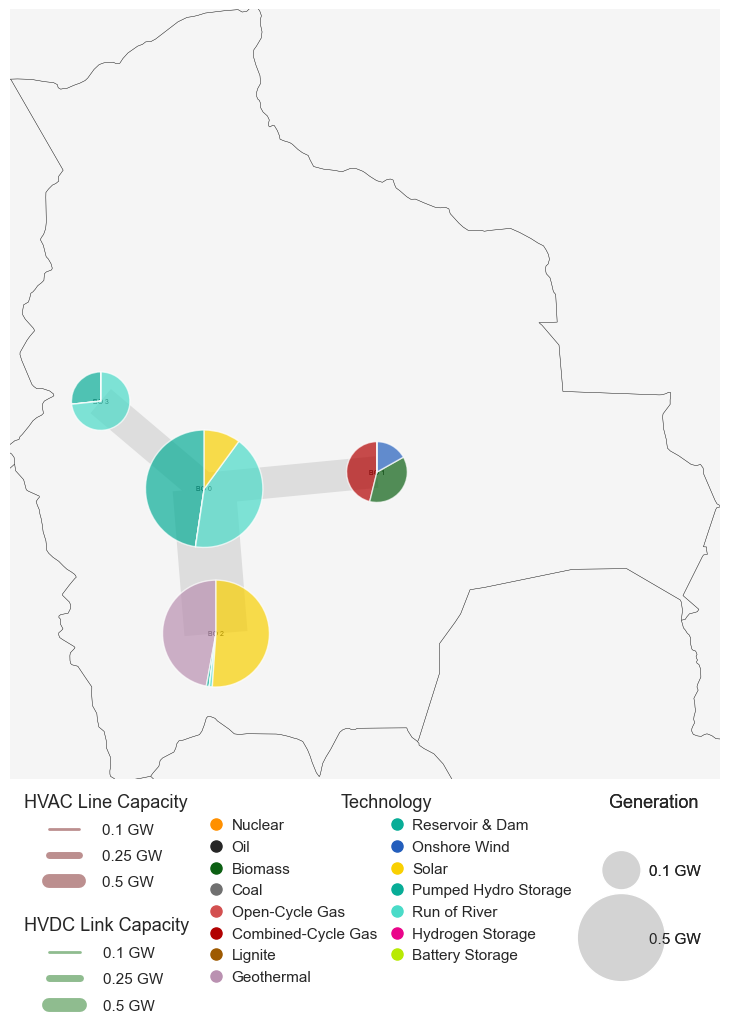

In [81]:
import cartopy.crs as ccrs
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch


def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (
            300.0 / fig.dpi
        )

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]


def add_legend(ax, bus_factor, branch_factor):

    handles = []
    labels = []
    for s in (0.1, 0.25, 0.5):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / branch_factor)
        )
        labels.append(f"{s} GW")
    l1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0, 0),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title="HVAC Line Capacity",
        title_fontsize=13,
        fontsize=11,
    )
    ax.add_artist(l1)

    handles = []
    labels = []
    for s in (0.1, 0.25, 0.5):
        handles.append(
            plt.Line2D(
                [0], [0], color="darkseagreen", linewidth=s * 1e3 / branch_factor
            )
        )
        labels.append(f"{s} GW")
    l2 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.0, -0.16),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title="HVDC Link Capacity",
        title_fontsize=13,
        fontsize=11,
    )
    ax.add_artist(l2)

    handles = []
    labels = []
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")
    for name, carrier in n.carriers.iterrows():
        handles.append(
            plt.Line2D(
                [0], [0], color=carrier.color, marker="o", markersize=8, linewidth=0
            )
        )
        labels.append(carrier.nice_name)
    l3 = ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.53, -0.0),  # bbox_to_anchor=(0.72, -0.05),
        handletextpad=0.0,
        columnspacing=0.3,
        ncol=2,
        title="Technology",
        title_fontsize=13,
        fontsize=11,
        frameon=False,
    )
    ax.add_artist(l3)

    circles = [1, 5]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{float(s/1e1)} GW" for s in circles]
    l4 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.82, 0.0),
        frameon=False,
        labelspacing=3.5,
        title="Generation",
        title_fontsize=13,
        fontsize=11,
        handler_map=make_handler_map_to_scale_circles_as_in(ax, True),
    )
    ax.add_artist(l4)


def plot_network(n, fn=None):

    bus_factor = 1.0e3
    branch_factor = 5e1

    fields = ["bus", "carrier", "p_nom","p_nom_opt"]
        
    pie_components = pd.concat(
        [
            n.generators.loc[n.generators.carrier != "load", fields],
            n.storage_units[fields],
        ]
    )
    bus_sizes = pie_components.groupby(["bus", "carrier"]).p_nom_opt.sum() / bus_factor

    def clip(df, thres=500):
        return df.where(df > thres, other=0.0)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = n.lines.s_nom_opt / branch_factor

    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    n.plot(
        ax=ax,
        bus_sizes=bus_sizes,
        color_geomap=True,
        bus_alpha=0.7,
        line_widths=line_widths_opt,
        line_colors="#dddddd",
    )

    n.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        line_widths=line_widths,
        link_widths=link_widths,
    )


    # Convert "Bus" index column to string type
    filtered_buses = n.buses
    filtered_buses.index = filtered_buses.index.astype(str)
    filtered_buses = n.buses[~n.buses.index.str.contains(r" (H2|battery)$")]
    
    # Add bus names to the plot
    for bus, (lon, lat) in filtered_buses[['x', 'y']].iterrows():
        ax.text(lon, lat, bus, fontsize=5, color='black', ha='center', va='center')


    add_legend(ax, bus_factor, branch_factor)

    ### section added to define the national border
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    shapes=world[world.name.isin(["Bolivia"])].set_index("name")
    ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")


plot_network(n)

# Expansion analysis

In [130]:
#   - It seems that while the model run before, due to restrictions on simulation, proper solving wasn't possible (by increasing tolerances of the solver the model gets actual results)
# Eur/Year

n.objective

112286728.55025029

In [17]:
# Check generators total capacities nominal (p_nom) optimized (p_nom_opt) 
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31376\2871636601.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_cap = n.generators.groupby(["carrier"]).sum()


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,
CCGT,NaN,0.000000,1.236000e+02,168938.245618,1.000,123.6,25.780434,0,1.236000e+02,2.000,0,0,0,2,0,0.0,2.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,2.0,2.0
OCGT,NaN,0.000000,0.000000e+00,141703.684213,1.170,0.0,43.183196,0,0.000000e+00,3.000,0,0,0,3,0,0.0,3.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,3.0,3.0
biomass,NaN,0.000000,9.900000e+01,556030.719012,0.936,99.0,29.934495,2,9.908000e+01,2.000,0,0,0,2,0,0.0,2.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,2.0,2.0
geothermal,inf,0.000000,5.500000e+01,334431.013779,0.239,55.0,0.009572,1,3.899580e+02,1.000,0,0,0,1,0,0.0,1.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,1.0,1.0
load,NaN,0.000000,4.000000e+09,0.000000,4.000,0.0,4.040597,0,4.000000e+09,0.004,0,0,0,4,0,0.0,4.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,4.0,4.0
oil,inf,0.000000,0.000000e+00,38234.561404,0.393,0.0,130.236490,0,0.000000e+00,1.000,0,0,0,1,0,0.0,1.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,1.0,1.0
onwind,2.375877e+06,160337.837381,4.500000e+01,437182.277006,4.000,45.0,0.098765,4,4.509236e+01,4.000,0,0,0,4,0,0.0,4.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,4.0,4.0
ror,NaN,611.770000,6.117700e+02,812822.145848,2.700,0.0,0.031157,0,6.117700e+02,3.000,0,0,0,3,0,0.0,3.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,3.0,3.0
solar,1.869811e+06,330825.879637,1.004000e+02,203423.833068,4.000,100.4,0.079582,4,5.236000e+02,4.000,0,0,0,4,0,0.0,4.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,4.0,4.0


In [19]:
#installed capacity expansion
generation_expansion = gen_cap['p_nom_opt'] - gen_cap['p_nom']
generation_expansion

carrier
CCGT            0.000000
OCGT            0.000000
biomass         0.080003
geothermal    334.958024
load            0.000000
oil             0.000000
onwind          0.092361
ror             0.000000
solar         423.200027
dtype: float64

In [15]:
#energy generated by type of powerplant
production_cap = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()
production_cap.sum()

carrier
CCGT          8.851482e+05
OCGT          0.000000e+00
biomass       5.351344e+05
geothermal    3.402168e+06
load          1.560521e+06
oil           0.000000e+00
onwind        5.599721e+04
ror           2.314994e+06
solar         9.115392e+05
dtype: float64

In [13]:
#Transmission lines 
lines = n.lines
lines

,bus0,bus1,length,type,s_max_pu,s_nom,capital_cost,num_parallel,s_nom_extendable,s_nom_min,x,r,b,build_year,carrier,x_pu_eff,r_pu_eff,s_nom_opt,v_nom,g,s_nom_max,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,BO 0,BO 1,391.346902,Al/St 240/40 4-bundle 380.0,0.7,1966.224077,14907.865551,1.157895,True,1138.340255,83.143428,10.139442,0.001965,0,AC,0.001718,0.000209,1138.365297,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,BO 0,BO 2,343.826310,Al/St 240/40 4-bundle 380.0,0.7,3932.448154,13098.400254,2.315789,True,2276.680510,36.523731,4.454114,0.003452,0,AC,0.000755,0.000092,2276.683536,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,BO 0,BO 3,312.570567,Al/St 240/40 4-bundle 380.0,0.7,1966.224077,11909.449175,1.157895,True,1138.340255,66.407038,8.098419,0.001569,0,AC,0.001372,0.000167,1138.392234,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [21]:
#transmission capacity expansion
transmission_expansion = lines['s_nom_opt'] - lines['s_nom']
transmission_expansion

Line
1    -827.858779
2   -1655.764617
3    -827.831842
dtype: float64

In [22]:
load_shedding = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()["load"]
load_shedding.sum()

1560521.122723128

# Operational parameters

In [75]:
n.objective/1000000

112.28672855025029

In [26]:
n.statistics()

Capacity Factor  Capital Expenditure  \
            carrier                                                    
Generator   Biomass                6.165563e-01         2.754576e+07   
            Combined-Cycle Gas     8.175107e-01         1.044038e+07   
            Geothermal             9.959415e-01         1.304141e+08   
            Oil                             NaN         0.000000e+00   
            Onshore Wind           1.417618e-01         4.928395e+06   
            Open-Cycle Gas                  NaN         0.000000e+00   
            Run of River           4.319740e-01         1.657534e+08   
            Solar                  1.987337e-01         2.662818e+07   
            load                   4.453542e-08         0.000000e+00   
Line        AC                     1.290711e-01         6.034913e+07   
Link        H2 electrolysis        2.638503e-01         2.010737e+05   
            H2 fuel cell           2.388757e-02         8.906061e+05   
            battery charger        1.716833e-01         1.400673e+05   
            battery discharger     1.390636e-01         0.000000e+00   
Load        -                               NaN                  NaN   
StorageUnit Reservoir & Dam        2.322236e-01         8.823570e+07   
Store       Battery Storage        4.815966e-01         1.281842e+05   
            Hydrogen Storage       4.537820e-01         1.588899e+05   

                                Curtailment  Installed Capacity  \
            carrier                                               
Generator   Biomass                0.000000        9.900000e+01   
            Combined-Cycle Gas     0.000000        1.236000e+02   
            Geothermal             0.000000        5.500000e+01   
            Oil                    0.000000        0.000000e+00   
            Onshore Wind           0.383389        4.500000e+01   
            Open-Cycle Gas         0.000000        0.000000e+00   
            Run of River           3.679554        6.117700e+02   
            Solar                  2.529820        1.004000e+02   
            load                   0.000000        4.000000e+09   
Line        AC                          NaN        7.864896e+03   
Link        H2 electrolysis             NaN        0.000000e+00   
            H2 fuel cell                NaN        0.000000e+00   
            battery charger             NaN        0.000000e+00   
            battery discharger          NaN        0.000000e+00   
Load        -                           NaN                 NaN   
StorageUnit Reservoir & Dam        0.000000        5.493200e+02   
Store       Battery Storage             NaN        0.000000e+00   
            Hydrogen Storage            NaN        0.000000e+00   

                                Operational Expenditure  Optimal Capacity  \
            carrier                                                         
Generator   Biomass                        9.143824e+02      9.908000e+01   
            Combined-Cycle Gas             1.302465e+03      1.236000e+02   
            Geothermal                     3.717485e+00      3.899580e+02   
            Oil                            0.000000e+00      0.000000e+00   
            Onshore Wind                   1.642265e-01      4.509236e+01   
            Open-Cycle Gas                 0.000000e+00      0.000000e+00   
            Run of River                   2.707555e+00      6.117700e+02   
            Solar                          2.099571e+00      5.236000e+02   
            load                           1.798346e+02      4.000000e+09   
Line        AC                                      NaN      4.553441e+03   
Link        H2 electrolysis                0.000000e+00      4.120835e+00   
            H2 fuel cell                   0.000000e+00      3.641349e+01   
            battery charger                0.000000e+00      3.637383e+00   
            battery discharger             0.000000e+00      4.041537e+00   
Load        -     

In [69]:
# Capital expenditure for optimized values (annual values based on p_nom_opt) [Eur/year]
n.statistics.capex().sum()

515813838.4308655

In [67]:
# Capital expenditure (annual values based on p_nom_opt) [Eur/year]
n.statistics.opex(aggregate_time="sum").sum()

21081471.935939964

In [71]:
#manual sum of components to obtain capex of the system [Million Eur/year]
capex = (n.generators.p_nom_opt * n.generators.capital_cost).div(1e6).sum()  + (n.storage_units.p_nom_opt * n.storage_units.capital_cost).div(1e6).sum() + (n.lines.s_nom_opt * n.lines.capital_cost).div(1e6).sum() + (n.stores.e_nom_opt * n.stores.capital_cost).div(1e6).sum()# M€/a
capex

514.5820912897459

In [60]:
#manual sum of components to obatin opex of the system [Million Eur/year]
opex = (n.snapshot_weightings.generators @ n.generators_t.p * (n.generators.marginal_cost).div(1e6)).sum() + (n.snapshot_weightings.generators @ n.storage_units_t.p * (n.storage_units.marginal_cost).div(1e6)).sum()  # M€/a
opex

21.081471935939966

In [80]:
#manual sum of components to obtain capex of only the expanded capacity (p_nom_opt-p_nom) [Million Eur/year]
capex2 = ((n.generators.p_nom_opt - n.generators.p_nom)* n.generators.capital_cost).div(1e6).sum()  + ((n.storage_units.p_nom_opt - n.storage_units.p_nom ) * n.storage_units.capital_cost).div(1e6).sum() + ((n.lines.s_nom_opt - n.lines.s_nom) * n.lines.capital_cost).div(1e6).sum() + ((n.stores.e_nom_opt - n.stores.e_nom) * n.stores.capital_cost).div(1e6).sum()# M€/a
capex2

89.97350888699383